# `method` on zf

# running `method` on zf

## imports

In [369]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [370]:
!pip install scanpy -q

In [371]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [372]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [373]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [374]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [375]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [376]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]


Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks

In [377]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
# exclude_rows = [1099, None, None, 325, None, None]

## load features and spatial coords specific to the triple

In [378]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]

## form cost matrices

In [379]:
%%time
Aiis_np = []

for i, X in enumerate(Xs):
    Aii_np = cdist(X, X)
    Aiis_np += [Aii_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 821 ms, sys: 45.1 ms, total: 866 ms
Wall time: 862 ms


## factor cost matrices

In [380]:
rank_list = [(3,7),(7,7),(7,11),(11,14),(14,19)]
#exclude_rows = [1099, None, None, 325, None, None]

C_factors_sequence = []
A_factors_sequence = []

for i in range(len(rank_list)):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Loading slices {s1_name} to {s2_name}')

    r1, r2 = rank_list[i]
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

    filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
    save_dir = filehandle_pair
    C_matrix = cdist(Xs[i], Xs[i+1])
    C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                    device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
    C_factors_sequence.append(C_factors12)
    if i == 0:
        A_factors_sequence.append(A_factors11)
        A_factors_sequence.append(A_factors22)
    else:
        A_factors_sequence.append(A_factors22)


c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
c = max(c, 1/c)
for i in range(len(C_factors_sequence)):
    C = C_factors_sequence[i]
    C_factors_sequence[i] = (C[0]/c, C[1]/c)

Loading slices zf3 to zf5
C done
A done
B done
Loading slices zf5 to zf10
C done
A done
B done
Loading slices zf10 to zf12
C done
A done
B done
Loading slices zf12 to zf18
C done
A done
B done
Loading slices zf18 to zf24
C done
A done
B done


## set OT hyperparameters

In [381]:
gamma=500
tau_out=1e1
tau_in=5e-8
alpha = 0.1
beta = 0.0

max_iter=100
min_iter=100

## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.9388216516924065e-09, GW-cost: 5.4954175123138514e-12, Total cost: 3.5454890282743974e-09
Final Wasserstein cost: 3.4917818783244396e-09, GW-cost: 8.81185389485181e-12, Total cost: 3.143484875881481e-09


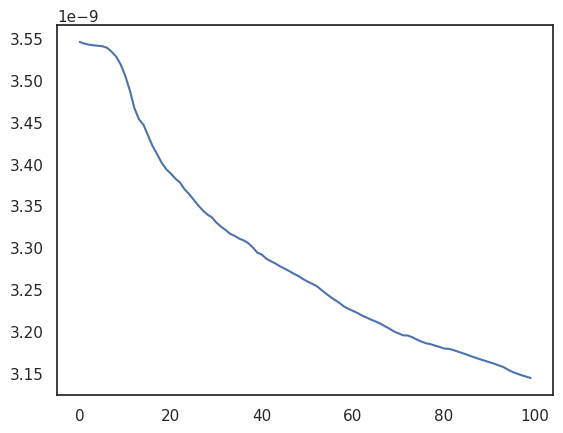

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.139285113320763e-09, GW-cost: 1.8879558544756097e-13, Total cost: 3.725375481547232e-09
Final Wasserstein cost: 3.8581012434012565e-09, GW-cost: 1.4334222526110843e-12, Total cost: 3.4724344612863918e-09


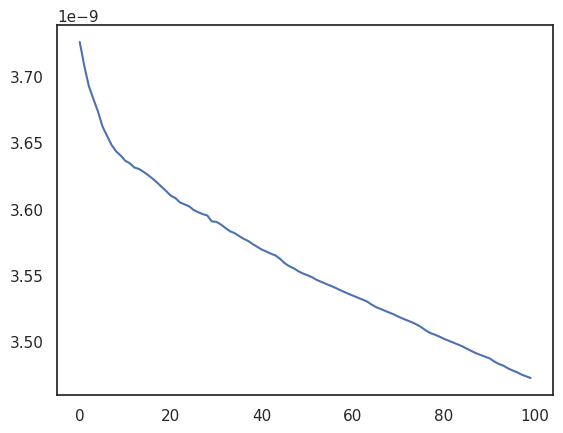

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.8259996097136095e-09, GW-cost: 5.840562233950023e-14, Total cost: 2.5434054893044825e-09
Final Wasserstein cost: 2.5755270692307192e-09, GW-cost: 1.5543461020857572e-13, Total cost: 2.3179899057686684e-09


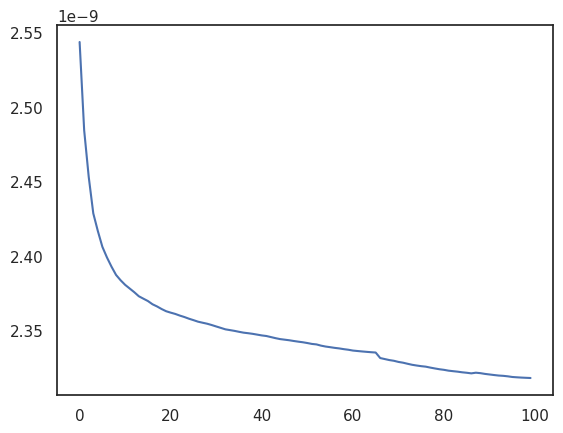

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.089542570935554e-09, GW-cost: 3.8085602447308775e-13, Total cost: 2.780626399444446e-09
Final Wasserstein cost: 2.8597975526793625e-09, GW-cost: 5.643468429410793e-13, Total cost: 2.5738742320957203e-09


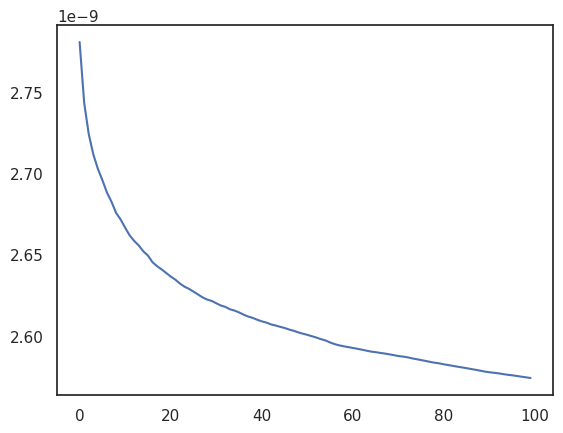

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.4437391679507748e-09, GW-cost: 1.3325326822631968e-12, Total cost: 3.099498504423924e-09
Final Wasserstein cost: 2.6248857697283936e-09, GW-cost: 6.839456139826764e-13, Total cost: 2.3624655873169524e-09


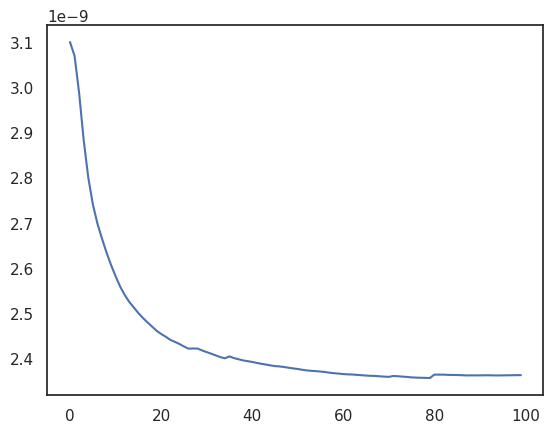

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.0978314651541315e-09, GW-cost: 1.49453107782083e-12, Total cost: 2.7881977717465006e-09
Final Wasserstein cost: 2.756883658836704e-09, GW-cost: 3.6913608550247064e-13, Total cost: 2.4812322065615837e-09


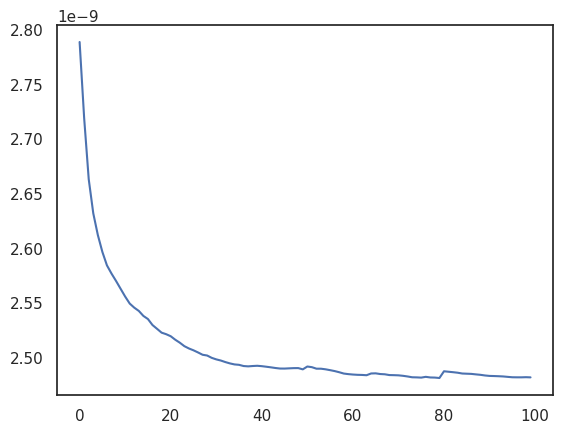

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.6135564711628336e-09, GW-cost: 2.190368679226172e-12, Total cost: 2.352419860914473e-09
Final Wasserstein cost: 2.375885324209601e-09, GW-cost: 1.6017030043275218e-12, Total cost: 2.1384569620890738e-09


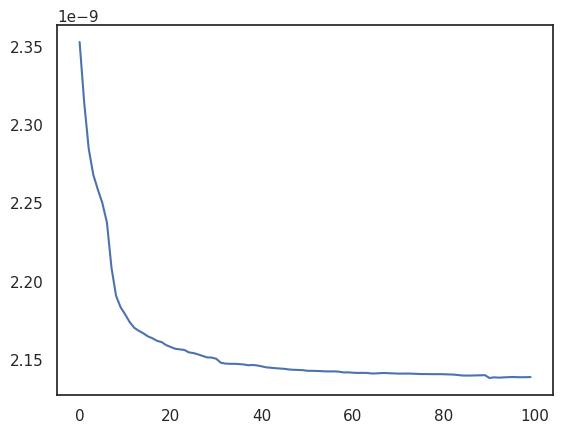

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.934009673063628e-09, GW-cost: 3.1382301181843825e-12, Total cost: 3.540922528769084e-09
Final Wasserstein cost: 3.815387887437907e-09, GW-cost: 2.080105220434413e-12, Total cost: 3.4340571092161597e-09


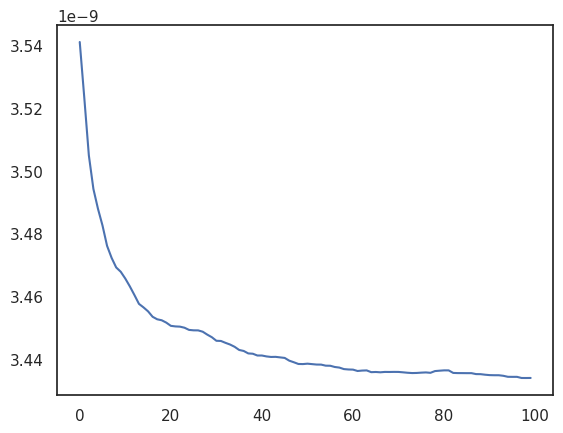

Ranks: r1 3, r2 7, r3 7
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 7.856283480290748e-09
Final Wasserstein-sum cost: 7.647674914944147e-09


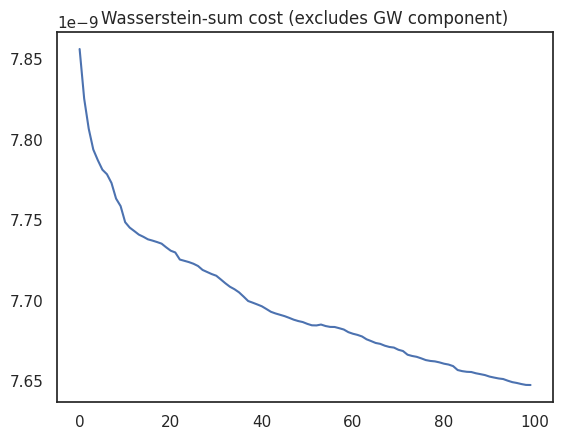

Ranks: r1 7, r2 7, r3 11
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.784420413021013e-09
Final Wasserstein-sum cost: 6.285215883775823e-09


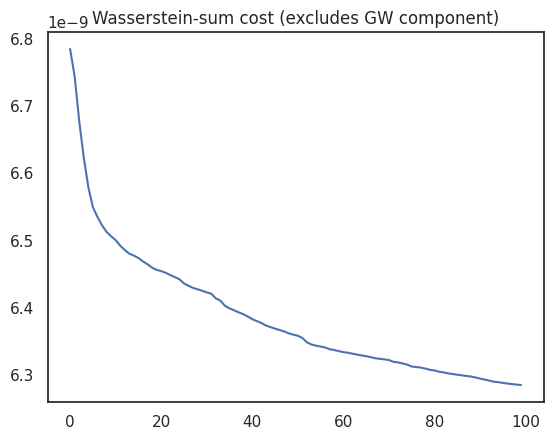

Ranks: r1 7, r2 11, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.029962319803253e-09
Final Wasserstein-sum cost: 5.36641976296854e-09


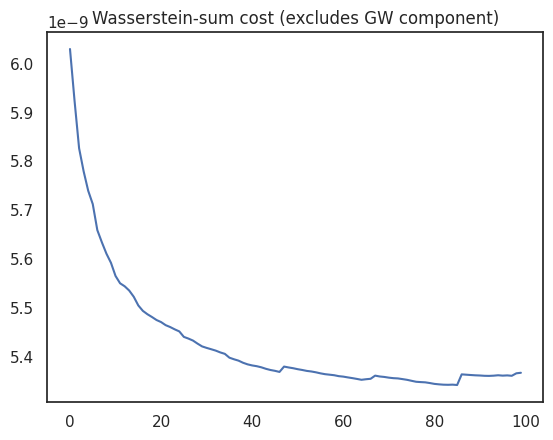

Ranks: r1 11, r2 14, r3 19
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 6.152651515328476e-09
Final Wasserstein-sum cost: 5.578215519356693e-09


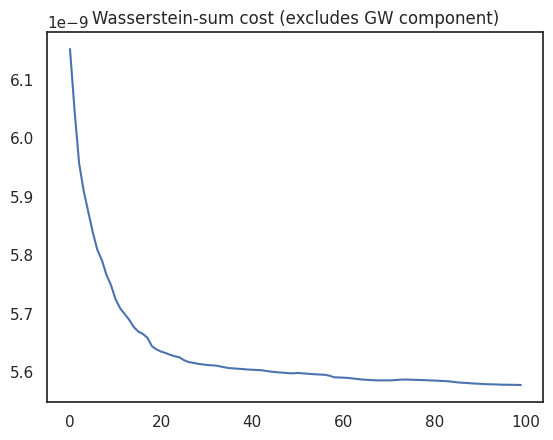

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.8265265912908045e-09, GW-cost: 6.141697765604556e-12, Total cost: 3.4444881019382845e-09
Final Wasserstein cost: 3.758228445647467e-09, GW-cost: 5.963214977599641e-12, Total cost: 3.3830019225804808e-09


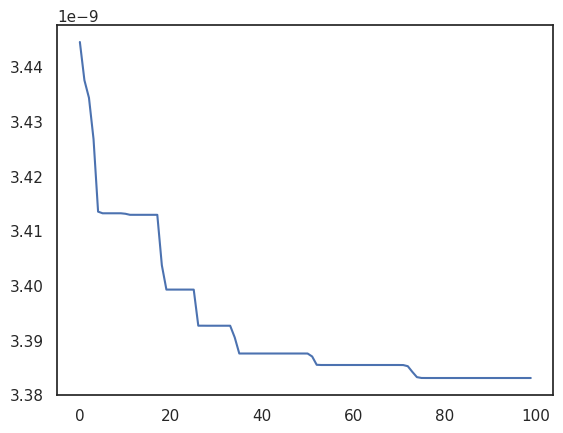

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.9038357305360964e-09, GW-cost: 2.9289912276714395e-12, Total cost: 3.5137450566052538e-09
Final Wasserstein cost: 3.804669320330488e-09, GW-cost: 2.8887922972639095e-12, Total cost: 3.424491267527165e-09


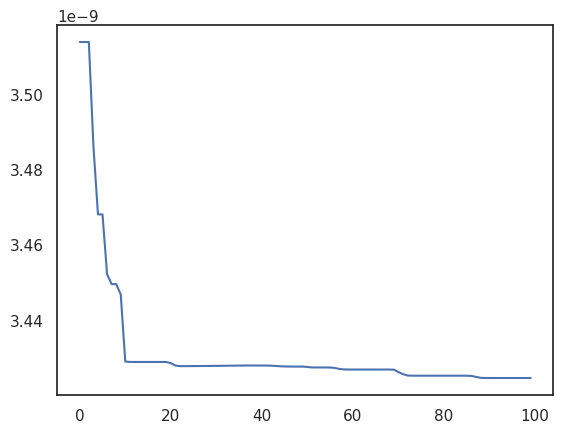

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.6594878982837086e-09, GW-cost: 1.33262159534507e-12, Total cost: 2.3936723706148724e-09
Final Wasserstein cost: 2.4325349610348743e-09, GW-cost: 1.0186971675147587e-12, Total cost: 2.1893833346481383e-09


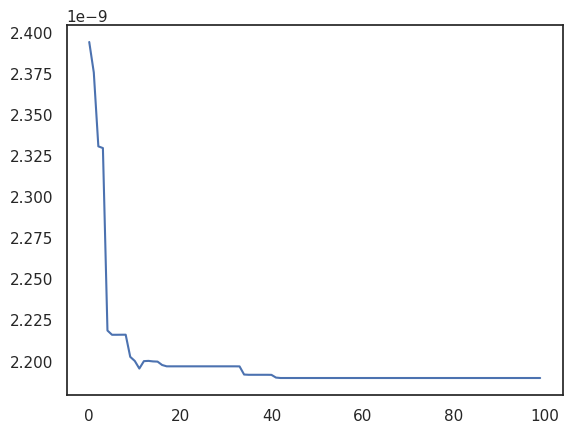

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9898696520750773e-09, GW-cost: 2.501097119193829e-13, Total cost: 2.6909076978387614e-09
Final Wasserstein cost: 2.8632215579146006e-09, GW-cost: 9.494691067850664e-14, Total cost: 2.576908896814208e-09


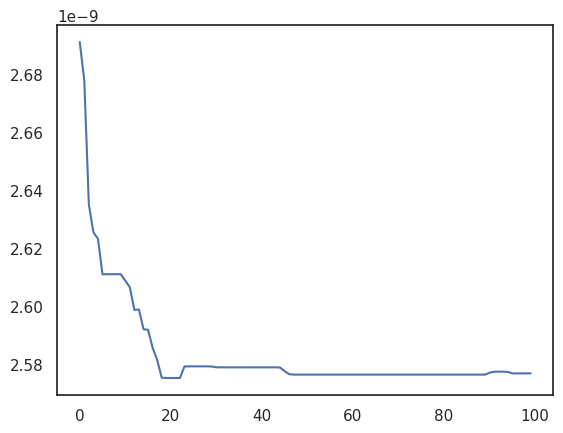

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9996795837062538e-09, GW-cost: 1.5042338069426651e-12, Total cost: 2.699862048716323e-09
Final Wasserstein cost: 2.679793419389531e-09, GW-cost: 1.1157263109556583e-12, Total cost: 2.4119256500816736e-09


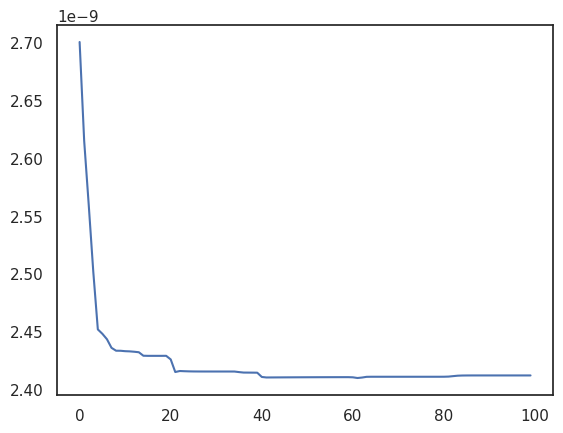

CPU times: user 5min 14s, sys: 3.78 s, total: 5min 17s
Wall time: 5min 13s


In [382]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(rank_list, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

In [383]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1)

Output hidden; open in https://colab.research.google.com to view.

## save

In [384]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [385]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [386]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.182 (filtered: 0.182) 	
AMI for 0th slice is 0.179 (filtered: 0.179)


ARI for 1th slice is 0.152 (filtered: 0.159) 	
AMI for 1th slice is 0.163 (filtered: 0.177)


ARI for 2th slice is 0.160 (filtered: 0.167) 	
AMI for 2th slice is 0.167 (filtered: 0.170)


ARI for 3th slice is 0.063 (filtered: 0.072) 	
AMI for 3th slice is 0.205 (filtered: 0.200)


ARI for 4th slice is 0.180 (filtered: 0.174) 	
AMI for 4th slice is 0.316 (filtered: 0.286)


ARI for 5th slice is 0.224 (filtered: 0.231) 	
AMI for 5th slice is 0.433 (filtered: 0.437)




In [401]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [402]:
util_zf.silhouette(gt_types_list, pred_types_list, Xs, Ss)

	Pred clusters 0 have **HIGHER** expression silhouette score: 0.078 > 0.027
	Pred clusters 1 have **LOWER** expression silhouette score: -0.003 < 0.016
	Pred clusters 2 have **LOWER** expression silhouette score: 0.001 < 0.010
	Pred clusters 3 have **LOWER** expression silhouette score: -0.016 < -0.001
	Pred clusters 4 have **HIGHER** expression silhouette score: 0.036 > -0.005
	Pred clusters 5 have **HIGHER** expression silhouette score: 0.039 > -0.004


	Pred clusters 0 have **HIGHER** spatial silhouette score: 0.078 > 0.004
	Pred clusters 1 have **HIGHER** spatial silhouette score: -0.003 > -0.139
	Pred clusters 2 have **LOWER** spatial silhouette score: 0.001 < 0.022
	Pred clusters 3 have **LOWER** spatial silhouette score: -0.016 < 0.059
	Pred clusters 4 have **HIGHER** spatial silhouette score: 0.036 > -0.055
	Pred clusters 5 have **HIGHER** spatial silhouette score: 0.039 > -0.132


## freezing $Q$s with annotations, running `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.936466431470239e-09, GW-cost: 5.455113693469461e-12, Total cost: 3.5433652996925623e-09
Final Wasserstein cost: 3.915401394376492e-09, GW-cost: 5.2981436075074185e-12, Total cost: 3.524391069299594e-09


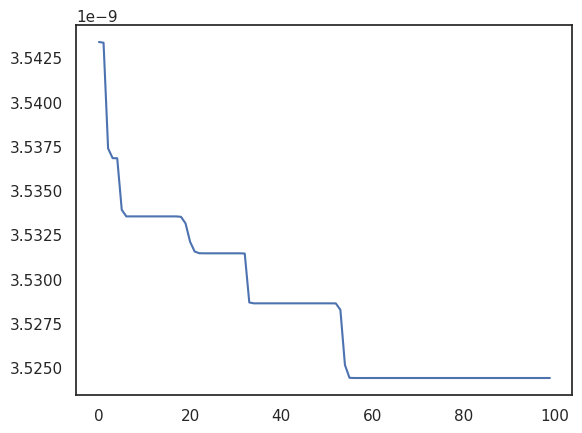

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 4.054533160027547e-09, GW-cost: 2.3248529270901907e-12, Total cost: 3.6493123293175015e-09
Final Wasserstein cost: 4.017550756939533e-09, GW-cost: 2.4061511420738448e-12, Total cost: 3.6160362963597873e-09


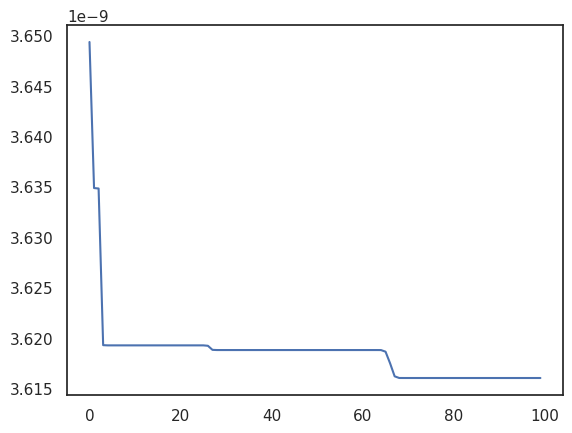

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 2.9052472762223037e-09, GW-cost: 9.333081797334534e-13, Total cost: 2.6148158794180467e-09
Final Wasserstein cost: 2.753444888323834e-09, GW-cost: 6.437039531253077e-13, Total cost: 2.478164769886763e-09


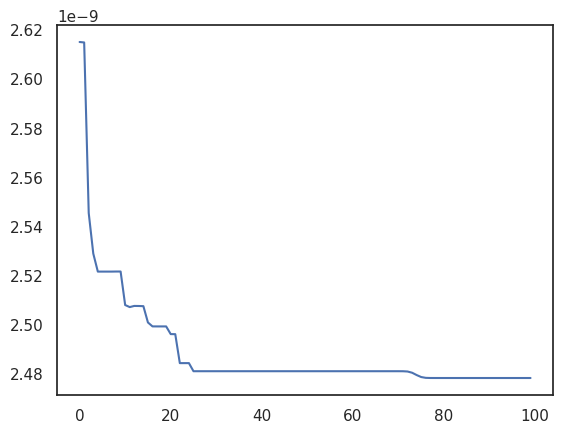

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.3000289162498087e-09, GW-cost: 9.67541645415153e-13, Total cost: 2.9701227787893695e-09
Final Wasserstein cost: 3.1332063058816436e-09, GW-cost: 8.882864280147001e-13, Total cost: 2.8199745039362807e-09


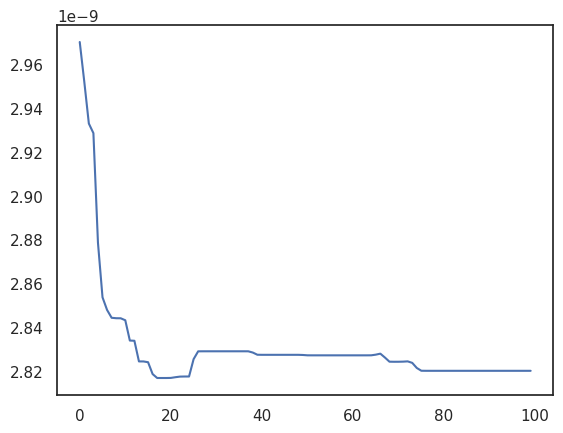

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 3.3768436637306977e-09, GW-cost: 1.1519942806611327e-12, Total cost: 3.039274496785694e-09
Final Wasserstein cost: 3.1123267340390434e-09, GW-cost: 9.578548638917681e-13, Total cost: 2.8011898461215282e-09


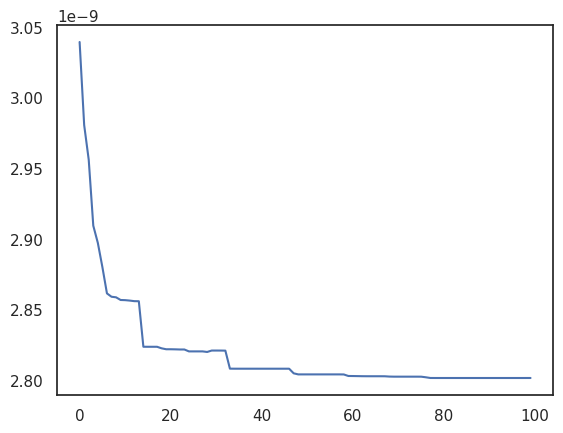

CPU times: user 1min 8s, sys: 1.12 s, total: 1min 9s
Wall time: 1min 8s


In [389]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [390]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [391]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [392]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [404]:
util_zf.compare_T_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)

Pred transitions 0 -> 1 are **MORE** entropic: 2.130 > 1.863
Pred transitions 1 -> 2 are **MORE** entropic: 2.331 > 2.292
Pred transitions 2 -> 3 are **MORE** entropic: 2.598 > 2.346
Pred transitions 3 -> 4 are **MORE** entropic: 2.917 > 2.661
Pred transitions 4 -> 5 are **MORE** entropic: 3.123 > 2.945


Pred transitions 0 -> 1 have **MORE** column entropy: 2.130 > 0.781
Pred transitions 1 -> 2 have **LESS** column entropy: 2.331 < 3.073
Pred transitions 2 -> 3 have **MORE** column entropy: 2.598 > 2.040
Pred transitions 3 -> 4 have **LESS** column entropy: 2.917 < 3.647
Pred transitions 4 -> 5 have **LESS** column entropy: 3.123 < 4.997


# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

# form cases
cell_type_labels_case_1 = [ct_ann_0, ct_ann_1, ct_ann_2]
cell_type_labels_case_2 = [ct_ann_0, None, ct_ann_2]
cell_type_labels_case_3 = [None, None, None]

## case 1: `ml` clustering,  annotations

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf